<a href="https://colab.research.google.com/github/DulithMH/Banking-Default-Prediction-EWS/blob/main/Risk_classifier_using_Digital_Twin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import random

# --- CONFIG ---
np.random.seed(42)
random.seed(42)
n_rows = 10000

# --- GENERATE DATA ---
data = {
    'Customer_ID': [f"CUST_{i}" for i in range(n_rows)],
    'PARM02': np.random.choice(['Textile', 'Construction', 'Tourism', 'Agri'], n_rows),
    'Snapshot_Date': np.random.choice(['2024-03-31', '2024-06-30'], n_rows),
    # 1. Missing Values created later
    'Gross_Loan': np.random.exponential(scale=500000, size=n_rows),
    'user_field_3': np.random.choice(['CURR', 'S130', 'N001', 'R001'], n_rows, p=[0.9, 0.05, 0.03, 0.02]),
    'tot_dpds': np.random.choice([0, 30, 60, 90, 120], n_rows, p=[0.85, 0.08, 0.04, 0.02, 0.01])
}
df = pd.DataFrame(data)

# --- INJECT DEFECTS ---
# Defect A: Missing Values (10% Loans, 5% Codes)
df.loc[np.random.choice(df.index, size=int(n_rows*0.1)), 'Gross_Loan'] = np.nan
df.loc[np.random.choice(df.index, size=int(n_rows*0.05)), 'user_field_3'] = np.nan

# Defect B: Outliers (The "Whales")
outliers = np.random.choice(df.index, size=20)
df.loc[outliers, 'Gross_Loan'] = df.loc[outliers, 'Gross_Loan'] * 50

# Defect C: Imbalance (Define Target)
df['Target'] = df.apply(lambda x: 1 if x['tot_dpds'] > 90 or x['user_field_3'] == 'R001' else 0, axis=1)

# Save
df.to_csv("dirty_banking_data.csv", index=False)
print("✅ Dirty Dataset Created!")

✅ Dirty Dataset Created!


In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score

In [28]:
# 1. LOAD (Don't touch anything yet!)
df = pd.read_csv("dirty_banking_data.csv")
features = ['Gross_Loan', 'tot_dpds', 'user_field_3']
X = df[features]
y = df['Target']

In [29]:
# STEP 2: SPLIT FIRST (The Golden Rule)
# We separate the "Exam Paper" (Test) before we start studying.
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
print(f"Original Train Shape: {X_train.shape}")

Original Train Shape: (8000, 3)


In [31]:
print(f"Original Train Shape: {X_test.shape}")

Original Train Shape: (2000, 3)


In [32]:
from sklearn.impute import SimpleImputer
import pandas as pd

# ==========================================
# 1. IMPUTE GROSS_LOAN (Numerical -> Median)
# ==========================================

# Define the imputer (Median strategy ignores outliers)
num_imputer = SimpleImputer(strategy='median')

# FIT on Train only (Learn the median from historical data)
num_imputer.fit(X_train[['Gross_Loan']])

# TRANSFORM both Train and Test (Apply that median to fill holes)
# We assign it back to the specific column to keep the DataFrame structure
X_train['Gross_Loan'] = num_imputer.transform(X_train[['Gross_Loan']])
X_test['Gross_Loan'] = num_imputer.transform(X_test[['Gross_Loan']])


# ==========================================
# 2. IMPUTE USER_FIELD_3 (Categorical -> Mode)
# ==========================================

# Define the imputer (Most Frequent = Mode)
cat_imputer = SimpleImputer(strategy='most_frequent')

# FIT on Train only (Find the most common code, e.g., 'CURR')
cat_imputer.fit(X_train[['user_field_3']])

# TRANSFORM both Train and Test
# Note: .ravel() is used to flatten the array format returned by the imputer
X_train['user_field_3'] = cat_imputer.transform(X_train[['user_field_3']]).ravel()
X_test['user_field_3'] = cat_imputer.transform(X_test[['user_field_3']]).ravel()

# ==========================================
# 3. VERIFY THE RESULT
# ==========================================
print("Missing values in Train Gross_Loan:", X_train['Gross_Loan'].isna().sum())
print("Missing values in Test user_field_3:", X_test['user_field_3'].isna().sum())

Missing values in Train Gross_Loan: 0
Missing values in Test user_field_3: 0


In [33]:
import numpy as np

# ==========================================
# STEP A: CALCULATE THE LIMIT (Train Only)
# ==========================================
# We define the "Whale" line at the 99th percentile of the Training set
upper_limit = X_train['Gross_Loan'].quantile(0.99)

print(f"The Cap Limit is: {upper_limit:,.2f}")

The Cap Limit is: 2,413,995.94


In [34]:
# STEP B: APPLY THE CAP (Train & Test)
# ==========================================
# If a value is higher than the limit, replace it with the limit.
# Otherwise, leave it alone.
# Cap Training Data
X_train['Gross_Loan'] = np.where(
    X_train['Gross_Loan'] > upper_limit,
    upper_limit,
    X_train['Gross_Loan']
)
# Cap Testing Data (Crucial: Use the SAME 'upper_limit' variable)
X_test['Gross_Loan'] = np.where(
    X_test['Gross_Loan'] > upper_limit,
    upper_limit,
    X_test['Gross_Loan']
)

2. Handling Imbalance (SMOTE)
The Rule: You must generate synthetic customers only in the Training set. The Test set must remain "Real" (Pure) so you can test if the model works on real people.

Note: You need to install the library first if you haven't: pip install imbalanced-learn

In [36]:
# ==========================================
# STEP 1: ENCODE TEXT TO NUMBERS
# ==========================================
# SMOTE requires pure numbers. We must map the text codes to integers.

# 1. Define the Map (Logic: Higher number = Higher Risk)
risk_map = {
    'CURR': 0,
    'S130': 1,
    'N001': 2,
    'R001': 3
}

# 2. Apply Mapping to Train and Test
# This converts "CURR" -> 0, "R001" -> 3
X_train['Restructure_Code'] = X_train['user_field_3'].map(risk_map)
X_test['Restructure_Code'] = X_test['user_field_3'].map(risk_map)

# ==========================================
# STEP 2: DROP THE TEXT COLUMN
# ==========================================
# CRITICAL: You must remove the original 'user_field_3' column.
# If you leave it, SMOTE will try to use it and crash again.
X_train = X_train.drop(columns=['user_field_3'])
X_test = X_test.drop(columns=['user_field_3'])

# Verify all columns are numbers
print("Data Types in X_train:")
print(X_train.dtypes)
# Look for 'object' or 'string'. If you see any, SMOTE will fail.

# ==========================================
# STEP 3: NOW RUN SMOTE
# ==========================================
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("✅ SMOTE Run Successfully!")

Data Types in X_train:
Gross_Loan          float64
tot_dpds              int64
Restructure_Code      int64
dtype: object
✅ SMOTE Run Successfully!


In [38]:
import xgboost as xgb

# 1. Initialize the Model
model = xgb.XGBClassifier(
    n_estimators=100,    # Number of trees
    max_depth=4,         # Depth of trees (keep low to avoid overfitting)
    learning_rate=0.05,  # Speed of learning
    random_state=42,
    eval_metric='logloss'
)

# 2. TRAIN on the BALANCED data (Synthetic Mix)
model.fit(X_train_balanced, y_train_balanced)

print("✅ Model Trained Successfully on SMOTE Data!")

✅ Model Trained Successfully on SMOTE Data!



--- CLASSIFICATION REPORT (Real World Test) ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1944
           1       0.84      1.00      0.91        56

    accuracy                           0.99      2000
   macro avg       0.92      1.00      0.95      2000
weighted avg       1.00      0.99      0.99      2000

ROC-AUC Score: 1.0000


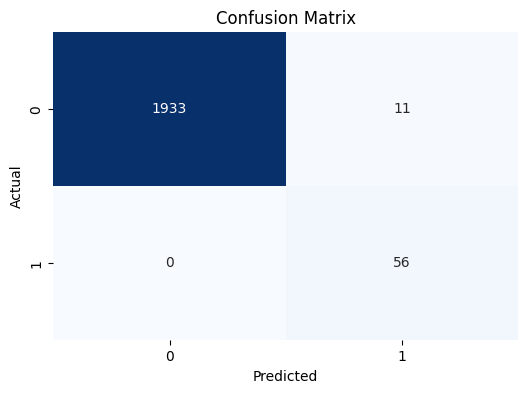

In [39]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. PREDICT on the REAL Test Data
y_pred = model.predict(X_test)                # Returns 0 or 1
y_prob = model.predict_proba(X_test)[:, 1]    # Returns probability (0.85, 0.12...)

# 2. GENERATE REPORT
print("\n--- CLASSIFICATION REPORT (Real World Test) ---")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# 3. VISUALIZE CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [40]:
import pandas as pd

# Create a final dataframe for review
results = pd.DataFrame({
    'Actual_Status': y_test,
    'Predicted_Prob': y_prob
})

# Define Logic: Banking Traffic Light System
def get_risk_status(prob):
    if prob > 0.70: return '🔴 Critical Risk'
    elif prob > 0.40: return '🟡 Watchlist'
    else: return '🟢 Safe'

results['Risk_Bucket'] = results['Predicted_Prob'].apply(get_risk_status)

# Show Summary: How many High Risk loans did we find?
print("\n--- PORTFOLIO RISK SUMMARY ---")
print(results['Risk_Bucket'].value_counts())


--- PORTFOLIO RISK SUMMARY ---
Risk_Bucket
🟢 Safe             1933
🔴 Critical Risk      67
Name: count, dtype: int64


In [41]:
from google.colab import files

# 1. Save the dataframe to a CSV on the cloud first
# (Replace 'df' with the name of your dataframe, e.g., 'results' or 'df_master')
df.to_csv('my_banking_project_data.csv', index=False)

# 2. Download it to your local computer
files.download('my_banking_project_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
!pip install gradio

In [43]:
import gradio as gr
import pandas as pd
import numpy as np

# ==========================================
# 1. DEFINE THE PREDICTION FUNCTION
# ==========================================
def predict_risk(gross_loan, tot_dpds, user_field_3):

    # A. Create a DataFrame from the Input
    # We must match the EXACT column names used in training
    input_data = pd.DataFrame({
        'Gross_Loan': [gross_loan],
        'tot_dpds': [tot_dpds],
        'user_field_3': [user_field_3]
    })

    # B. Preprocessing (MUST MATCH TRAINING EXACTLY)

    # 1. Map Text to Numbers (The user selects text, we convert to code)
    # Using the 'risk_map' we defined earlier
    risk_map = {'CURR': 0, 'S130': 1, 'N001': 2, 'R001': 3}
    input_data['Restructure_Code'] = input_data['user_field_3'].map(risk_map)

    # 2. Drop the text column (Model doesn't know it)
    input_data = input_data.drop(columns=['user_field_3'])

    # 3. Cap Outliers (Using the 'upper_limit' from Training)
    # Ensure input_data matches the feature order: ['Gross_Loan', 'tot_dpds', 'Restructure_Code']
    # If Gross Loan is missing (None), fill it (Simple logic for demo)
    if input_data['Gross_Loan'].isnull().any():
         input_data['Gross_Loan'] = 50000 # Default fallback

    input_data['Gross_Loan'] = np.where(
        input_data['Gross_Loan'] > upper_limit,
        upper_limit,
        input_data['Gross_Loan']
    )

    # C. Get Prediction
    # prob is the probability of default (0.0 to 1.0)
    prob = model.predict_proba(input_data)[:, 1][0]

    # D. Return Readable Output
    if prob > 0.70:
        return f"🔴 CRITICAL RISK ({prob:.1%})", "Reject Loan"
    elif prob > 0.40:
        return f"🟡 WATCHLIST ({prob:.1%})", "Review Manually"
    else:
        return f"🟢 SAFE ({prob:.1%})", "Approve"

In [44]:
# ==========================================
# 2. DEFINE THE VISUALS
# ==========================================

# Inputs: What the Loan Officer types
inputs = [
    gr.Number(label="Gross Loan Amount ($)", value=50000),
    gr.Slider(0, 180, step=30, label="Days Past Due (DPD)"),
    gr.Dropdown(['CURR', 'S130', 'N001', 'R001'], label="Restructure Status", value='CURR')
]

# Outputs: What the App shows back
outputs = [
    gr.Textbox(label="Risk Status"),
    gr.Textbox(label="Recommended Action")
]

# ==========================================
# 3. LAUNCH THE APP
# ==========================================
interface = gr.Interface(
    fn=predict_risk,          # The logic function
    inputs=inputs,            # The input boxes
    outputs=outputs,          # The output boxes
    title="🏦 Bank Default Early Warning System",
    description="Enter customer details to predict the probability of default using the XGBoost Digital Twin Model."
)

# Launch it!
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://72c4a7c9582a4b8ae1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
